Early stopping of model simulations
===================

In [1]:
from pyabc import (ABCSMC,
                   RV, Distribution,
                   IntegratedModel, ModelResult,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.sampler import SingleCoreSampler
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tempfile
import pandas as pd
import scipy as sp
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

We define here a (very) simple stochastic process, purely for demonstrative reasons.
First, we fix the number of steps *n_steps* to 30.

In [2]:
n_steps = 30

We then define our process as follows:

$$
   x(t+1) = x(t) + s \xi
$$

in which $\xi \sim U(0, 1)$ denotes a uniformly in $[0, 1]$ distributed
random variable and *s* is the step size, *s = step_size*.

The function *simulate* implements this stochastic process.

In [3]:
def simulate(step_size):
    trajectory = sp.zeros(n_steps)
    for t in range(1, n_steps):
        xi = sp.rand()
        trajectory[t] = trajectory[t-1] + xi * step_size
    return trajectory

We take as distance function between two such generated trajectories
the sum of the absolute values of the pointwise differences.

In [4]:
def distance(trajectory_1, trajectory_2):
    return sp.absolute(trajectory_1 - trajectory_2).sum()

Let's run the simulation and plot the trajectories to get a better
idea of the so generated data.
We set the ground truth step size *gt_step_size* to 

In [5]:
gt_step_size = 5

This will be used to generate the data which will be subject to inference later on.

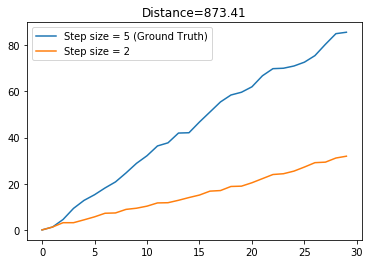

In [6]:
gt_trajectory = simulate(gt_step_size)
trajectoy_2 = simulate(2)

dist_1_2 = distance(gt_trajectory, trajectoy_2)

plt.plot(gt_trajectory,
    label="Step size = {} (Ground Truth)".format(gt_step_size))
plt.plot(trajectoy_2,
    label="Step size = 2")
plt.legend();
plt.title("Distance={:.2f}".format(dist_1_2));

In [7]:
class MyStochasticProcess(IntegratedModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.n_early_stopped = 0
    
    def integrated_simulate(self, pars, eps):
        cumsum = 0
        trajectory = sp.zeros(n_steps)
        for t in range(1, n_steps):
            xi = sp.rand()
            next_val = trajectory[t-1] + xi * pars["step_size"]
            cumsum += abs(next_val - gt_trajectory[t])
            trajectory[t] = next_val
            if cumsum > eps:
                self.n_early_stopped += 1
                return ModelResult(accepted=False)
            
        return ModelResult(accepted=True,
                           distance=cumsum,
                           sum_stats={"trajectory": trajectory})

In [8]:
prior = Distribution(step_size=RV("uniform", 0 , 10))

In [9]:
model = MyStochasticProcess()

In [10]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=None,
             sampler=SingleCoreSampler(),
             population_size=30,
             transitions=LocalTransition(k_fraction=.2),
             eps=MedianEpsilon(300, median_multiplier=0.7))

In [11]:
abc.new(db_path)

INFO:Epsilon:initial epsilon is 300
INFO:History:Start <ABCSMC(id=2, start_time=2018-04-08 22:08:51.987917, end_time=None)>


2

In [12]:
h = abc.run(minimum_epsilon=40, max_nr_populations=3)

INFO:ABC:t:0 eps:300
INFO:ABC:t:1 eps:109.07814857607372
INFO:ABC:t:2 eps:57.50261699756532
INFO:History:Done <ABCSMC(id=2, start_time=2018-04-08 22:08:51.987917, end_time=2018-04-08 22:09:04.395984)>


In [13]:
model.n_early_stopped

2437

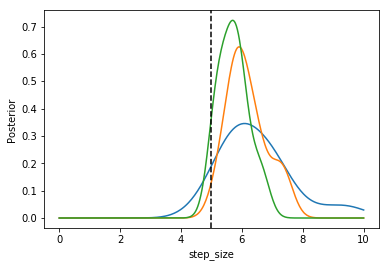

In [14]:
from pyabc.visualization import plot_kde_1d
fig, ax = plt.subplots()

for t in range(h.max_t+1):
    particles = h.get_distribution(m=0, t=t)
    plot_kde_1d(*particles, "step_size",
                label="t={}".format(t), ax=ax,
                xmin=0, xmax=10, numx=300)
ax.axvline(gt_step_size, color="k", linestyle="dashed");    